In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV

mycmap = "spring"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

# Importing and splitting data

In [39]:
dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.80*N) #75% training -> 25% test
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(x_test.shape)

(1000, 4)


# Original dataset visualization

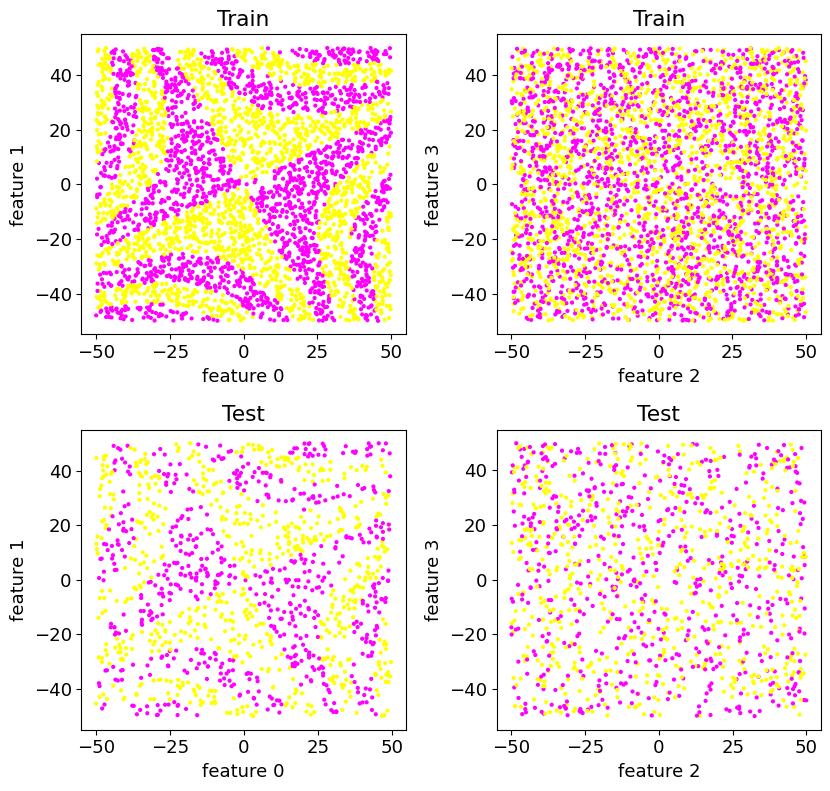

In [9]:
#original dataset visualization
def scatt(ax, x, y, i=0, j=1, s=4, title=""):
    ax.scatter(x[:,i], x[:,j], s=s, c=y)
    ax.set_xlabel(f'feature {i}')
    ax.set_ylabel(f'feature {j}')
    ax.set_title(title)

fig,ax=plt.subplots(2,2, figsize=(8.5,8.1))
scatt(ax[0,0], x_train, y_train, title='Train')
scatt(ax[0,1], x_train, y_train, i=2, j=3, title='Train')
scatt(ax[1,0], x_test, y_test, title='Test')
scatt(ax[1,1], x_test, y_test, i=2, j=3, title='Test')
plt.tight_layout()
plt.show()

# Default XGBClassifier performance

Cross Validation accuracy: 0.926 ± 0.011
Test accuracy: 0.922 ± 0.009


ValueError: 'c' argument has 800 elements, which is inconsistent with 'x' and 'y' with size 1000.

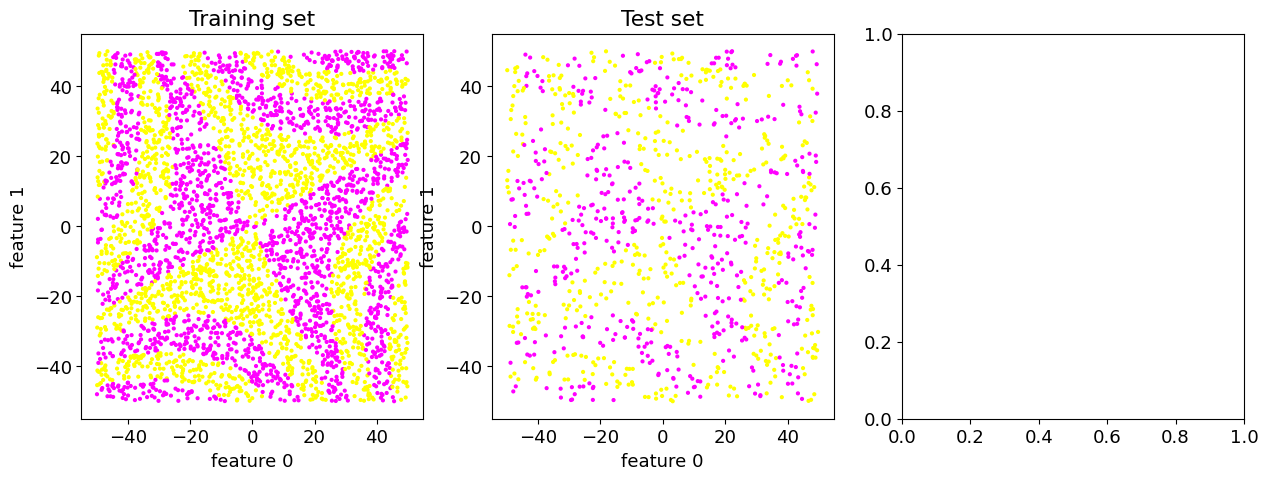

In [43]:
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.utils import resample

model = XGBClassifier(objective='binary:logistic', importance_type='gain')
############################################################################### CV
kf = KFold(n_splits=5, shuffle=True, random_state=None)
accuracies=[]

for train_indx, test_indx in kf.split(x_train):
    
    x_traink, x_testk = x_train[train_indx], x_train[test_indx]
    y_traink, y_testk = y_train[train_indx], y_train[test_indx]
    
    model.fit(x_traink, y_traink)
    y_test_hat = model.predict(x_testk)
    
    accuracy = np.sum(y_test_hat == y_testk)/len(y_testk)
    accuracies.append(accuracy)
    
    
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)

print(f"Cross Validation accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")
############################################################################## #bootstrapping / resampling
model.fit(x_train, y_train)
n_iterations=1000  
test_accuracies=[]

for i in range(n_iterations):

    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    test_accuracies.append(accuracy_resampled)

mean_accuracy_test=np.mean(test_accuracies)
std_dev_test=np.std(test_accuracies)

print(f"Test accuracy: {mean_accuracy_test:.3f} ± {std_dev_test:.3f}")
#######################################################################################
fig, ax = plt.subplots(1,3,figsize=(15,5))
scatt(ax[0], x_train, y_train, title='Training set')
scatt(ax[1], x_test, y_test, title='Test set')
scatt(ax[2], x_test, y_test_hat, title='Prediction on test set')
fig.tight_layout()
plt.show()

We performed a 5-fold cross-validation to evaluate the performance of the XGBoost model, obtaining an average accuracy of 0.935 ± 0.006. 
This confirmed the stability of the model on different splits of the dataset. 
Next, we trained the model on the entire training set to obtain the final model, which achieved an accuracy of 0.927 on the test data, 
confirming good generalization capabilities.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.utils import resample

model = XGBClassifier(objective='binary:logistic', importance_type='gain')
############################################################################### CV
kf = KFold(n_splits=5, shuffle=True, random_state=None)
accuracies=[]

for train_indx, test_indx in kf.split(x):
    
    x_train, x_test = x[train_indx], x[test_indx]
    y_train, y_test = y[train_indx], y[test_indx]
    
    model.fit(x_train, y_train)
    y_test_hat = model.predict(x_test)
    
    accuracy = np.sum(y_test_hat == y_test)/len(y_test)
    accuracies.append(accuracy)
    
    
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)

print(f"Cross Validation accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")
############################################################################## #bootstrapping / resampling
model.fit(x_train, y_train)
n_iterations=1000  
test_accuracies=[]

for i in range(n_iterations):

    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    test_accuracies.append(accuracy_resampled)

mean_accuracy_test=np.mean(test_accuracies)
std_dev_test=np.std(test_accuracies)

print(f"Test accuracy: {mean_accuracy_test:.3f} ± {std_dev_test:.3f}")
#######################################################################################
fig, ax = plt.subplots(1,3,figsize=(15,5))
scatt(ax[0], x_train, y_train, title='Training set')
scatt(ax[1], x_test, y_test, title='Test set')
scatt(ax[2], x_test, y_test_hat, title='Prediction on test set')
fig.tight_layout()
plt.show()

# GridSearch with CV for best hyperparameter selection

In [19]:
param_grid = {
    'n_estimators': [90, 100, 110],  
    'max_depth': [5, 6, 7],  
    'learning_rate': [0.2, 0.3, 0.4],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.8, 1, 1.2], 
    'reg_alpha': [0, 0.1, 0.2, 0.3], 
}
#100, 6, 0.3, 0, 1, 0
model = XGBClassifier(objective='binary:logistic', seed=1)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
cv_std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Best parameters found: ", best_params)
print(f"Best validation accuracy: {best_accuracy:.3f} ± {cv_std_dev:.3f}")

##########
model_best=grid_search.best_estimator_ 

n_iter=1000  
bootstrap_accuracies=[]

for i in range(n_iter):
    
    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model_best.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    bootstrap_accuracies.append(accuracy_resampled)


mean_accuracy = np.mean(bootstrap_accuracies)
std_dev = np.std(bootstrap_accuracies)

print(f"Bootstrap accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.2}
Best validation accuracy: 0.931 ± 0.012
Bootstrap accuracy: 0.953 ± 0.007


In [21]:
param_grid_trial2 = {
    'n_estimators': [95, 100, 105],  
    'max_depth': [6, 7, 8],  
    'learning_rate': [0.25, 0.3, 0.35], 
    'gamma': [0, 0.05, 0.1], 
    'reg_lambda': [0.9, 1, 1.1],  
    'reg_alpha': [0, 0.05, 0.1]  
}
model = XGBClassifier(objective='binary:logistic', seed=1)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
cv_std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Best parameters found: ", best_params)
print(f"Best validation accuracy: {best_accuracy:.3f} ± {cv_std_dev:.3f}")
##########
model_best=grid_search.best_estimator_ 

n_iter=1000  
bootstrap_accuracies=[]

for i in range(n_iter):
    
    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model_best.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    bootstrap_accuracies.append(accuracy_resampled)


mean_accuracy = np.mean(bootstrap_accuracies)
std_dev = np.std(bootstrap_accuracies)

print(f"Bootstrap accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.2}
Best validation accuracy: 0.931 ± 0.012
Bootstrap accuracy: 0.953 ± 0.007


It seems that the hyperparameter tuning with the narrower search space did not yield a better result than the previous trial. 
The best parameters and validation accuracy remained the same, with the model achieving a validation accuracy of 0.933. 
This suggests that the initial parameter choices were already quite effective and that small adjustments within this range do not significantly impact model performance. 
This could indicate that the model is already near its optimal configuration given the dataset and the problem.

In [23]:
param_grid_trial3 = {
    'n_estimators': [99, 100, 101],  
    'max_depth': [6, 7],  
    'learning_rate': [0.28, 0.3, 0.32], 
    'gamma': [0, 0.05, 0.1], 
    'reg_lambda': [0.05, 0.1, 0.15],  
    'reg_alpha': [0.9, 1, 1.1],  
}
model = XGBClassifier(objective='binary:logistic', seed=1)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
cv_std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Best parameters found: ", best_params)
print(f"Best validation accuracy: {best_accuracy:.3f} ± {cv_std_dev:.3f}")
##########
model_best=grid_search.best_estimator_ 

n_iter=1000  
bootstrap_accuracies=[]

for i in range(n_iter):
    
    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model_best.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    bootstrap_accuracies.append(accuracy_resampled)


mean_accuracy = np.mean(bootstrap_accuracies)
std_dev = np.std(bootstrap_accuracies)

print(f"Bootstrap accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.2}
Best validation accuracy: 0.931 ± 0.012
Bootstrap accuracy: 0.953 ± 0.006


It seems that, despite narrowing the hyperparameter search space further, the best combination of parameters remains unchanged, yielding the same validation accuracy of 0.933. This suggests that the model is relatively stable in this region of the hyperparameter space, and small adjustments may not significantly improve performance. 

In [25]:
param_grid_expanded = {
    'n_estimators': [50, 150, 200],  
    'max_depth': [3, 10, 15],  
    'learning_rate': [0.05, 0.1, 0.5],  
    'gamma': [0, 0.5, 1],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.5, 1]  
}
model = XGBClassifier(objective='binary:logistic', seed=1)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
cv_std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Best parameters found: ", best_params)
print(f"Best validation accuracy: {best_accuracy:.3f} ± {cv_std_dev:.3f}")
##########
model_best=grid_search.best_estimator_ 

n_iter=1000  
bootstrap_accuracies=[]

for i in range(n_iter):
    
    x_resampled, y_resampled=resample(x_test, y_test, n_samples=len(x_test), random_state=None)
    y_resampled_hat=model_best.predict(x_resampled)
    accuracy_resampled=np.sum(y_resampled_hat == y_resampled)/len(y_resampled)
    bootstrap_accuracies.append(accuracy_resampled)


mean_accuracy = np.mean(bootstrap_accuracies)
std_dev = np.std(bootstrap_accuracies)

print(f"Bootstrap accuracy: {mean_accuracy:.3f} ± {std_dev:.3f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.2}
Best validation accuracy: 0.931 ± 0.012
Bootstrap accuracy: 0.953 ± 0.007


Despite exploring a wider range of values for the hyperparameters, the performance has not significantly improved.

# Best model performance

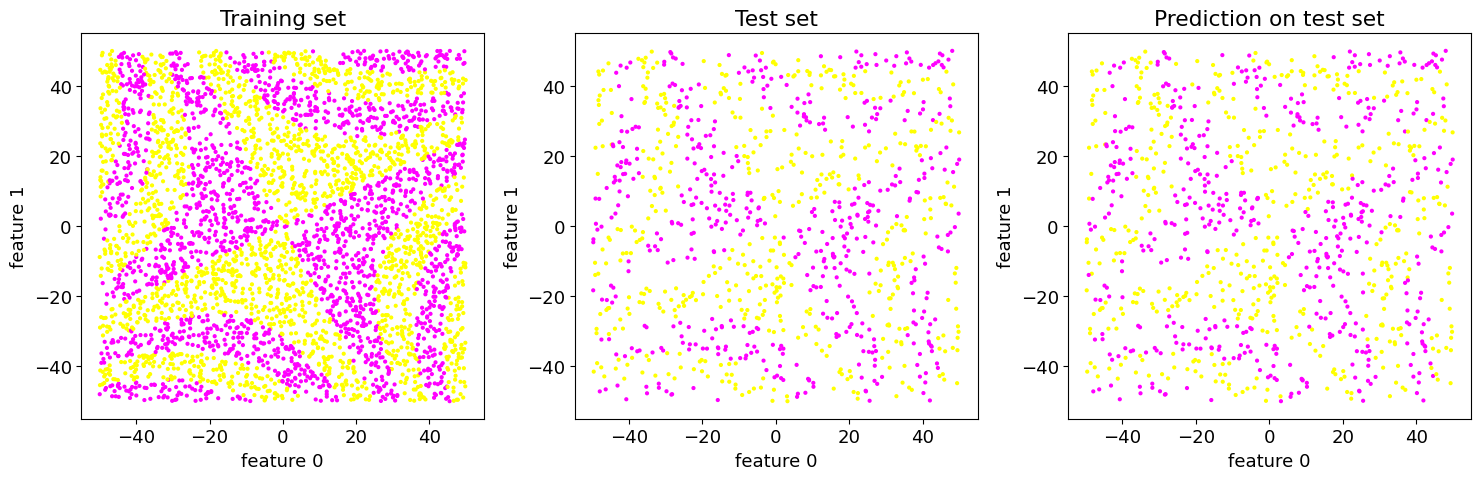

Test accuracy: 0.953


In [28]:
# Train the best model
best_model = grid_search.best_estimator_
y_test_hat = best_model.predict(x_test)
fig, ax = plt.subplots(1,3,figsize=(15,5))
scatt(ax[0], x_train, y_train, title='Training set')
scatt(ax[1], x_test, y_test, title='Test set')
scatt(ax[2], x_test, y_test_hat, title='Prediction on test set')
fig.tight_layout()
plt.show()
print("Test accuracy: {:.3f}".format(best_model.score(x_test, y_test)))